<a href="https://colab.research.google.com/github/harnalashok/CatEncodersFamily/blob/main/diabetes_pca_xgb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demo with diabetes data set
Data source is [here](https://www.kaggle.com/datasets/mathchi/diabetes-data-set).

In [ ]:
# Last amended: 6th June, 2023

## Basics

In [1]:
%reset -f

In [ ]:
!pip install catencfamily==0.0.65

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.6/228.6 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 50.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 90.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 101.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 101.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.1/174.1 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 81.7 MB/s eta 0:00:00
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395106 sha256=e870ff6a7d5cd9d70305a53c404eb49f90b3e3fc6c0c1734ad8522f4ba4b8558
  Stored in directory: /root/.cache/pip/wheels/b5/42/97/11eee99f5c1e4fdfc170f0a54f9c9eb195d

In [ ]:
# 1.0 Call libraries
import pandas as pd
import numpy as np


# 1.01
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# 1.02
import matplotlib.pyplot as plt
import seaborn as sns


# 1.03
import xgboost as xgb


# 1.04
from catencfamily.encoders import CatEncodersFamily
from catencfamily import utils

In [ ]:
# 1.05 Display multiple commands output from a cell:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [ ]:
# 2.0 Read diabetes Data:

data = pd.read_csv("https://raw.githubusercontent.com/harnalashok/CatEncodersFamily/main/datasets/diabetes.csv")
data.head(3)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [ ]:
# 2.1 Unique values in Pregnancies:
#     There are 15.
data['Pregnancies'].unique()

array([ 6,  1,  8,  0,  5,  3, 10,  2,  4,  7,  9, 11, 13, 15, 17, 12, 14])

In [ ]:
# 2.2
data.shape   # (768, 9)
print("\n==dtypes====\n")
data.dtypes

(768, 9)


==dtypes====



Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

In [ ]:
# 2.3 pop out target:

y = data.pop("Outcome")

# 2.2.1 Check nulls
data.isnull().sum().sum()

0

In [ ]:
# 2.2.2 Proportions of 1s and 0s
y.value_counts(normalize = True)

0    0.651042
1    0.348958
Name: Outcome, dtype: float64

In [ ]:
# 2.3 Check nulls and any need for imputing?

data.isnull().sum().sum()


0

## Transform numeric data to categorical
We transform our data as if it were categorical. (of course, such transformation is imperfect.)

To perform our experiments we bin all numeric columns to transform the data to categorical. Binning is performed using pandas `cut()` method. Subsequently we will transform the categorical data to numeric using the approach given in CatEncodersFamily.  

While binning, we also split the data: both the numeric (the original) as also the binned datasets. Spliting is performed in stratified manner using `train_test_split()` function of sklearn; `target (y)` is used to stratify. While splitting, for easy comparison, we  see to it that same set of rows occur in `orig_train` and `train_binned` on the one hand and `orig_test` and `test_binned` on the other hand. 

In [ ]:
# 3.0 Discretise all features but 'Pregnancies'. And also split dataset.
#     into train/test:

orig_train, orig_test, train_binned, test_binned  = utils.transformToCatFeatures(data.iloc[:,1:],
                                                                              y,
                                                                              bins = 30,
                                                                              test_size = 0.1,
                                                                              genColName = False  # Keep orig col names
                                                                              )

In [ ]:
# 3.0.1 Check  original data:
#       It has target col also:

orig_train.shape    # (692, 8)
print("\n======\n")
orig_train.head(3)
orig_test.head(3)


(692, 8)

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,target
661,62.0,78.0,0.0,0.0,32.6,0.391,41.0,0
610,95.0,72.0,33.0,0.0,37.7,0.370,27.0,0
675,131.0,0.0,0.0,0.0,43.2,0.270,26.0,1


,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,target
533,148.0,72.0,35.0,0.0,33.6,0.627,50.0,1
311,85.0,66.0,29.0,0.0,26.6,0.351,31.0,0
131,183.0,64.0,0.0,0.0,23.3,0.672,32.0,1


In [ ]:
# 3.0.2 Check discretised features
#       Note the row-indices of train/test data 
#       and compare with those in the above cell.

train_binned.shape
print("\n========\n")
train_binned.head(3)
test_binned.head(3)

(692, 8)

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,target
661,410,820,121,161,2015,245,2810,0
610,415,818,1210,161,2017,244,283,0
675,420,81,121,161,2020,243,283,1


,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,target
533,423,818,1211,161,2016,248,2815,1
311,413,817,129,161,2012,244,285,0
131,428,816,121,161,2011,248,286,1


In [ ]:
# 3.1 Pop out targets:

ytr = train_binned.pop('target')
yte = test_binned.pop("target")

## Transform categorical data to numeric
We use `CatEncodersFamily` class for transformation:

In [ ]:
## 4.0 Developing models
#      Which are our cat columns
#      We will consider all cat features 
# Ref: https://www.kaggle.com/code/kanncaa1/feature-selection-and-data-visualization


cat_cols = list(train_binned.columns)
len(cat_cols)  # 7


# 4.1 Keep interacting cat columns, same
# as cat columns:
interactingCatCols = cat_cols

7

In [ ]:
# 5.0 Instantiate CatEncodersFamily class:

ct = CatEncodersFamily(
                       cMeasures=[1,1,1,1,None,1,1],
                       )

# 5.1 Fit it using only train_binned dataset.
#     While fitting, 'target' is not needed:


ct.fit(train_binned, cat_cols, interactingCatCols) 

Record set no is 1  
Set of records is:  [('Glucose', 'BloodPressure', [1, 1, 1, 1, None, 1, 1]), ('Glucose', 'SkinThickness', [1, 1, 1, 1, None, 1, 1]), ('Glucose', 'Insulin', [1, 1, 1, 1, None, 1, 1]), ('Glucose', 'BMI', [1, 1, 1, 1, None, 1, 1]), ('Glucose', 'DiabetesPedigreeFunction', [1, 1, 1, 1, None, 1, 1]), ('Glucose', 'Age', [1, 1, 1, 1, None, 1, 1]), ('Glucose', 'Glucose_p_BMI', [1, 1, 1, 1, None, 1, 1]), ('Glucose', 'BloodPressure_p_Age', [1, 1, 1, 1, None, 1, 1]), ('Glucose', 'Insulin_p_Age', [1, 1, 1, 1, None, 1, 1]), ('Glucose', 'Glucose_p_Insulin', [1, 1, 1, 1, None, 1, 1]), ('Glucose', 'SkinThickness_p_Insulin', [1, 1, 1, 1, None, 1, 1]), ('Glucose', 'BloodPressure_p_Insulin', [1, 1, 1, 1, None, 1, 1]), ('Glucose', 'Insulin_p_DiabetesPedigreeFunction', [1, 1, 1, 1, None, 1, 1]), ('Glucose', 'Glucose_p_BloodPressure', [1, 1, 1, 1, None, 1, 1]), ('Glucose', 'SkinThickness_p_DiabetesPedigreeFunction', [1, 1, 1, 1, None, 1, 1]), ('Glucose', 'BMI_p_DiabetesPedigreeFunction',

CatEncodersFamily(cMeasures=[1, 1, 1, 1, None, 1, 1],
                  pathToStoreProgress=PosixPath('/content/allmodels/progress'))

## Data transformation:

In [ ]:
# 6.0 Transform both test_binned and train_binned data:
#     (Takes time...)

test_trans = ct.transform(test_binned[cat_cols])

f"Transformed test data shape: {test_trans.shape}"



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  945
====Sending model loading progress to file: /content/allmodels/progress/load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 0.477876 MB
Mem usage after dtype transformation is: 0.2441 MB


'Transformed test data shape: (76, 776)'

In [ ]:
# 6.0.1 Transform train_binned now:
#       (Takes time...)

train_trans= ct.transform(train_binned[cat_cols])

f"Transformed train data shape: {train_trans.shape}"



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  945
====Sending model loading progress to file: /content/allmodels/progress/load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 4.276748 MB
Mem usage after dtype transformation is: 2.148156 MB


'Transformed train data shape: (692, 776)'

Our new features are substantially difft from original features. Prefixes to feature names imply as below:  
<i>
>deg_ ===> This feature results from calculation of degree centrality<br>
>eig_ ===> This feature results from calculation of eigenvector centrality<br>
>pr_  ===> This feature results from calculation of page rank centrality<br>
>bet_ ===> This feature results from calculation of betweenness centrality<br>
>clu_ ===> This feature results from calculation of clustering characteristics<br>,</i>


In [ ]:
# 6.1 Observe data now:
#     It also has original binned cols (8):

train_trans.head(3)
test_trans.head(3)

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,deg_Glucose_ck_BloodPressure,eig_Glucose_ck_BloodPressure,pr_Glucose_ck_BloodPressure,...,eig_Age_ck_BloodPressure_p_DiabetesPedigreeFunction,pr_Age_ck_BloodPressure_p_DiabetesPedigreeFunction,clu_Age_ck_BloodPressure_p_DiabetesPedigreeFunction,bet_Age_ck_BloodPressure_p_DiabetesPedigreeFunction,eig_Age_ck_Glucose_p_Age,deg_Age_ck_Glucose_p_DiabetesPedigreeFunction,eig_Age_ck_Glucose_p_DiabetesPedigreeFunction,pr_Age_ck_Glucose_p_DiabetesPedigreeFunction,clu_Age_ck_Glucose_p_DiabetesPedigreeFunction,bet_Age_ck_Glucose_p_DiabetesPedigreeFunction
0,410,820,121,161,2015,245,2810,1.0,0.209261,0.043627,...,0.223448,0.044606,0.787879,0.015255,0.088008,0.846154,0.242594,0.050664,0.731602,0.033925
1,415,818,1210,161,2017,244,283,1.0,0.209261,0.043627,...,0.242177,0.050395,0.710000,0.030234,-0.275558,0.769231,0.230215,0.045544,0.805263,0.011643
2,420,81,121,161,2020,243,283,1.0,0.209261,0.043627,...,0.242177,0.050395,0.710000,0.030234,-0.275558,0.769231,0.230215,0.045544,0.805263,0.011643


,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,deg_Glucose_ck_BloodPressure,eig_Glucose_ck_BloodPressure,pr_Glucose_ck_BloodPressure,...,eig_Age_ck_BloodPressure_p_DiabetesPedigreeFunction,pr_Age_ck_BloodPressure_p_DiabetesPedigreeFunction,clu_Age_ck_BloodPressure_p_DiabetesPedigreeFunction,bet_Age_ck_BloodPressure_p_DiabetesPedigreeFunction,eig_Age_ck_Glucose_p_Age,deg_Age_ck_Glucose_p_DiabetesPedigreeFunction,eig_Age_ck_Glucose_p_DiabetesPedigreeFunction,pr_Age_ck_Glucose_p_DiabetesPedigreeFunction,clu_Age_ck_Glucose_p_DiabetesPedigreeFunction,bet_Age_ck_Glucose_p_DiabetesPedigreeFunction
0,423,818,1211,161,2016,248,2815,1.0,0.209261,0.043627,...,0.206884,0.040969,0.821053,0.011445,-0.045791,0.653846,0.193323,0.039619,0.757353,0.010484
1,413,817,129,161,2012,244,285,1.0,0.209261,0.043627,...,0.224870,0.050823,0.727273,0.091085,-0.151895,0.884615,0.250321,0.052080,0.711462,0.028903
2,428,816,121,161,2011,248,286,1.0,0.209261,0.043627,...,0.215377,0.042863,0.809524,0.012721,0.193729,0.730769,0.222121,0.043489,0.830409,0.011087


In [ ]:
# 6.2 Pop out target:

_= orig_train.pop('target')
_= orig_test.pop('target')

## xgboost modeling:

In [ ]:
# 7.0 Original train/test data:

evals_result= {}
model_orig = xgb.XGBClassifier( n_estimators= 200,
                               verbosity = 3,
                               eta = 0.06,      
                               max_depth = 6,
                               subsample = 0.8, 
                               evals_result = evals_result,
                               random_state = None,
                              )


tr_X =   orig_train
test_X = orig_test
ytr = ytr 
yte = yte 


model_orig.fit(tr_X, ytr.values,             
               early_stopping_rounds = 50,   
               eval_set=[ (tr_X, ytr.values), (test_X, yte.values)], 
               eval_metric = ['auc']        
              )



[14:01:20] WARNING: ../src/learner.cc:767: 
Parameters: { "evals_result" } are not used.

[14:01:20] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[14:01:20] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.89087	validation_1-auc:0.69105
[14:01:20] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.92553	validation_1-auc:0.76811
[14:01:20] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.92855	validation_1-auc:0.76243
[14:01:20] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.93892	validation_1-auc:0.76243
[14:01:20] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-auc:0.94243	validation_1-auc:0.75781
[14:01:20] INFO

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              evals_result={}, feature_types=None, gamma=None, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
# 7.1 Scores:

f"Best auc from orig train/test data: {model_orig.best_score}"
print("\n===========\n")
f"Best iteration from orig train/test data: {model_orig.best_iteration}"

'Best auc from orig train/test data: 0.7681107954545454'

'Best iteration from orig train/test data: 1'

In [ ]:
# 7.2 Modeling with transformed train/test data:

evals_result= {}
model_trans = xgb.XGBClassifier( n_estimators= 300,
                           verbosity = 3,
                           eta = 0.06,      
                           max_depth = 14,  # We have a large no of features
                           subsample = 0.9,        
                           evals_result = evals_result,
                           random_state = None,
                           )


tr_X =   train_trans.iloc[:,len(cat_cols):]  # ignore original cols
test_X = test_trans.iloc[:,len(cat_cols):] 
ytr = ytr 
yte = yte 


model_trans.fit(tr_X, ytr.values,     
          early_stopping_rounds = 250, 
          eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
          eval_metric = ['auc']    
          )



[14:01:33] WARNING: ../src/learner.cc:767: 
Parameters: { "evals_result" } are not used.

[14:01:33] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[14:01:33] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation_0-auc:0.94471	validation_1-auc:0.69744
[14:01:33] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=9
[1]	validation_0-auc:0.96861	validation_1-auc:0.70455
[14:01:34] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=9
[2]	validation_0-auc:0.97557	validation_1-auc:0.70881
[14:01:34] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=9
[3]	validation_0-auc:0.98341	validation_1-auc:0.70703
[14:01:34] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=9
[4]	validation_0-auc:0.98595	validation_1-auc:0.72621
[14:01:34] INF

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              evals_result={}, feature_types=None, gamma=None, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=14, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
# 7.3 Scores:

f"Best auc from transformed train/test data: {model_trans.best_score}"
print("\n===========\n")
f"Best iteration from orig train/test data: {model_trans.best_iteration}"

'Best auc from transformed train/test data: 0.7620738636363636'

'Best iteration from orig train/test data: 40'

### Learning curve plots

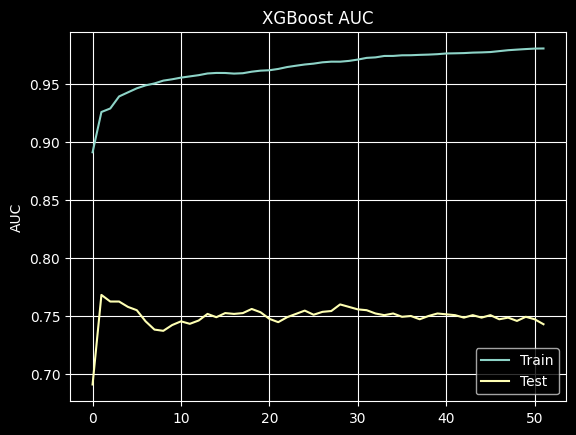

In [ ]:
# 7.4 Modeling with original data:

# Ref: https://stackoverflow.com/a/60366515
results = model_orig.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)
fig, ax = plt.subplots();
ax.plot(x_axis, results['validation_0']['auc'], label='Train');
ax.plot(x_axis, results['validation_1']['auc'], label='Test');
ax.legend();
plt.ylabel('AUC');
plt.grid()
plt.title('XGBoost AUC original data');
plt.show();

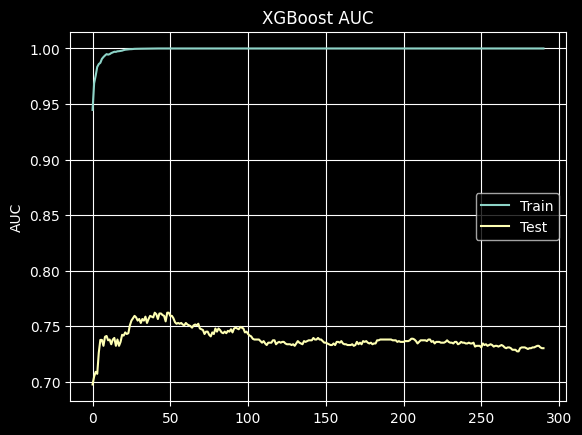

In [ ]:
# 7.5 Modeling with transformed data:

results = model_trans.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)
fig, ax = plt.subplots();
ax.plot(x_axis, results['validation_0']['auc'], label='Train');
ax.plot(x_axis, results['validation_1']['auc'], label='Test');
ax.legend();
plt.ylabel('AUC');
plt.grid()
plt.title('XGBoost AUC transformed data');
plt.show();

## Feature importance
Extract feature importance using function `utils.xgImptFeatures()`. The function outputs three objects as follows::  
>`fe_1`: List of columns arranged in order of descending xgboost impt(feat-impt >0)<br>
>`fe_0`: List of columns whose xgboost importance is zero<br>
>`fe`: One-column dataframe of feature importance(top-down). Col name is 'imp'<br>  

In [ ]:
# 8.0 Get feature importance:
#      fe: Sorted Pandas DataFrame with column name and top-down feature impt 

fe_1, fe_0, fe = utils.xgImptFeatures(model_trans,  train_trans.iloc[:,len(cat_cols):].columns)
print("\n=== DataFrame  of impt features top-down =======\n")
fe.iloc[:5]
print("\n\n== Column-list whose feat impt >0 =======\n")
fe_1[:5]  # Arranged in descending order of impt
print("\n\n===Column-list whose feat impt is 0 =======\n")
fe_0[:5]


Order of feature importance is by 'gain'

=== DataFrame  of impt features top-down =======



,imp
eig_Glucose_ck_SkinThickness_p_BMI,0.023684
deg_Glucose_ck_SkinThickness_p_Insulin,0.020059
eig_DiabetesPedigreeFunction_ck_BloodPressure_p_BMI,0.016031
clu_Age_ck_BloodPressure_p_DiabetesPedigreeFunction,0.014380
eig_Glucose_ck_BMI_p_Age,0.010553




== Column-list whose feat impt >0 =======



['eig_Glucose_ck_SkinThickness_p_BMI',
 'deg_Glucose_ck_SkinThickness_p_Insulin',
 'eig_DiabetesPedigreeFunction_ck_BloodPressure_p_BMI',
 'clu_Age_ck_BloodPressure_p_DiabetesPedigreeFunction',
 'eig_Glucose_ck_BMI_p_Age']



===Column-list whose feat impt is 0 =======



['clu_Glucose_ck_BMI',
 'deg_Glucose_ck_BMI',
 'clu_BloodPressure_ck_BMI',
 'deg_BloodPressure_ck_Insulin',
 'bet_BloodPressure_ck_Insulin']

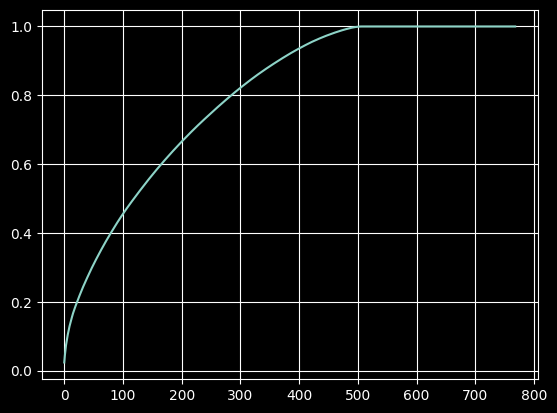

In [ ]:
# 8.1 Cumulative sum of feature importance.

plt.plot(range(len(fe)), fe['imp'].cumsum().values);
plt.grid();

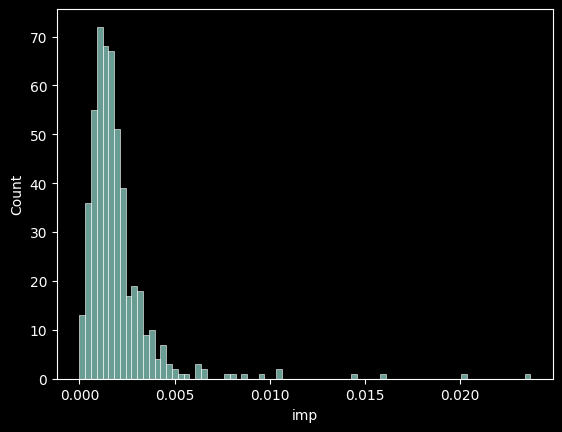

In [ ]:
# 8.2 A histogram plot of feature importance score
#      Most columns have feature impt below 0.0040

sns.histplot(fe['imp'][fe_1]);

In [ ]:
# 8.2 Modeling with transformed train/test data but with
#     features whose xgboost imp > 0 :

evals_result= {}
model_trans_imp = xgb.XGBClassifier( n_estimators= 300,
                           verbosity = 3,
                           eta = 0.06,      
                           max_depth = 14,  # We have a large no of features
                           subsample = 0.9,        
                           evals_result = evals_result,
                           random_state = None,
                           )


tr_X =   train_trans[fe_1]
test_X = test_trans[fe_1]
ytr = ytr 
yte = yte 


model_trans_imp.fit(tr_X, ytr.values,     
          early_stopping_rounds = 250, 
          eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
          eval_metric = ['auc']    
          )

[14:03:35] WARNING: ../src/learner.cc:767: 
Parameters: { "evals_result" } are not used.

[14:03:35] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[14:03:36] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation_0-auc:0.94209	validation_1-auc:0.68892
[14:03:36] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=9
[1]	validation_0-auc:0.96961	validation_1-auc:0.69460
[14:03:36] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=9
[2]	validation_0-auc:0.97590	validation_1-auc:0.71165
[14:03:36] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=9
[3]	validation_0-auc:0.98332	validation_1-auc:0.70845
[14:03:36] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=9
[4]	validation_0-auc:0.98571	validation_1-auc:0.73615
[14:03:36] INF

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              evals_result={}, feature_types=None, gamma=None, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=14, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None, ...)

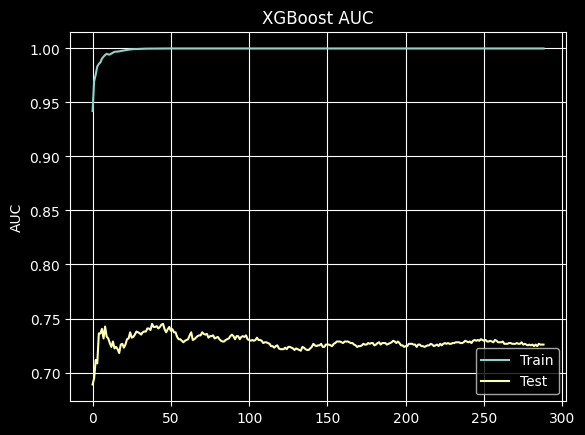

In [ ]:
# 8.3 Learning curve with revised transformed features:
#     It is better than with all transformed features.

results = model_trans_imp.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)
fig, ax = plt.subplots();
ax.plot(x_axis, results['validation_0']['auc'], label='Train');
ax.plot(x_axis, results['validation_1']['auc'], label='Test');
ax.legend();
plt.ylabel('AUC');
plt.grid()
plt.title('XGBoost AUC');
plt.show();

## PCA with original data and transformed data:

In [ ]:
# 9.0 PCA with original train data:

pca = PCA(n_components = 2,  whiten= True, random_state= None)
ss= StandardScaler()
orig_pca = pca.fit_transform(ss.fit_transform(orig_train[cat_cols]))
orig_pca.shape

(692, 2)

In [ ]:
# 9.1 PCA with transformed train data.
#     Only consider imp features after xgboost modeling

trans_pca = train_trans[fe_1]
pca = PCA(n_components= 2, whiten= True, random_state = None)
ss = StandardScaler()
trans_pca = pca.fit_transform(ss.fit_transform(trans_pca))
trans_pca.shape

(692, 2)

In [ ]:
# 9.2 Assign column names;

colnames = ["pc" + str(i) for i in range(orig_pca.shape[1])]
orig_pca  = pd.DataFrame(orig_pca, columns = colnames)
trans_pca = pd.DataFrame(trans_pca, columns = colnames)

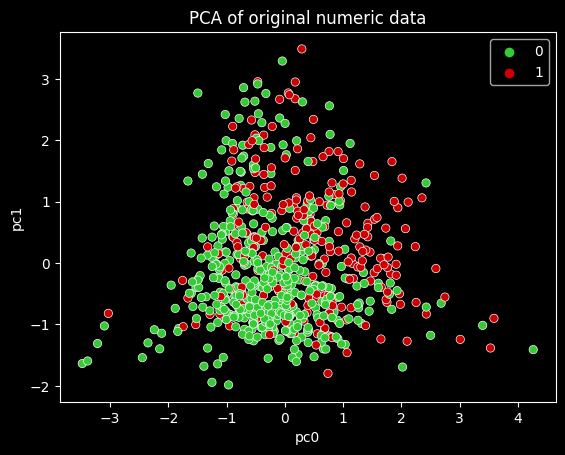

In [ ]:
# 9.3 PCA from original train data:

plt.style.use("dark_background")
sns.scatterplot(data = orig_pca ,
                x= 'pc0',
                y = 'pc1',
                hue = ytr.values,
                palette = ["#33cc33", "#cc0000"]
                ).set(title='PCA of original numeric data');


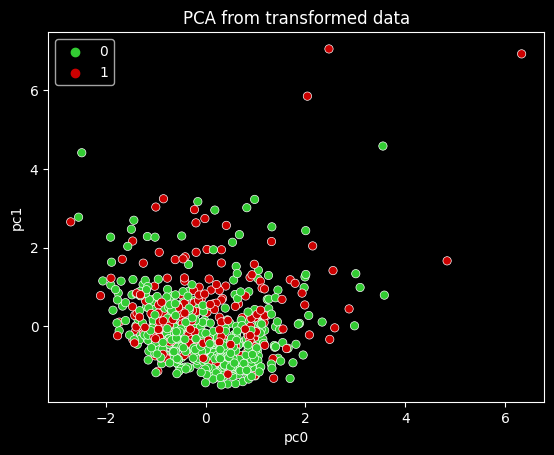

In [ ]:
# 9.4 PCA from transformed data:

plt.style.use("dark_background")
sns.scatterplot(data = trans_pca,
                x= 'pc0',
                y = 'pc1',
                hue = ytr.values,
                palette = ["#33cc33", "#cc0000"]
                ).set(title='PCA from transformed data') ;

## Correlation with orig columns
Correlation of extracted features with original features

In [ ]:
# 10.0 Take top 5 imp features:

tt = train_trans[fe_1[:10]].copy()
tt.shape  # (692, 10)

(692, 10)

In [ ]:
# 11.1 Reindex orig_train (ie numeric) and merge with 'tt':

ot= orig_train.reset_index(drop = True).copy()
result = ot.merge(tt, left_index = True, right_index=True )


Correlation heatmap shows good amount of correlation between the two sets of features

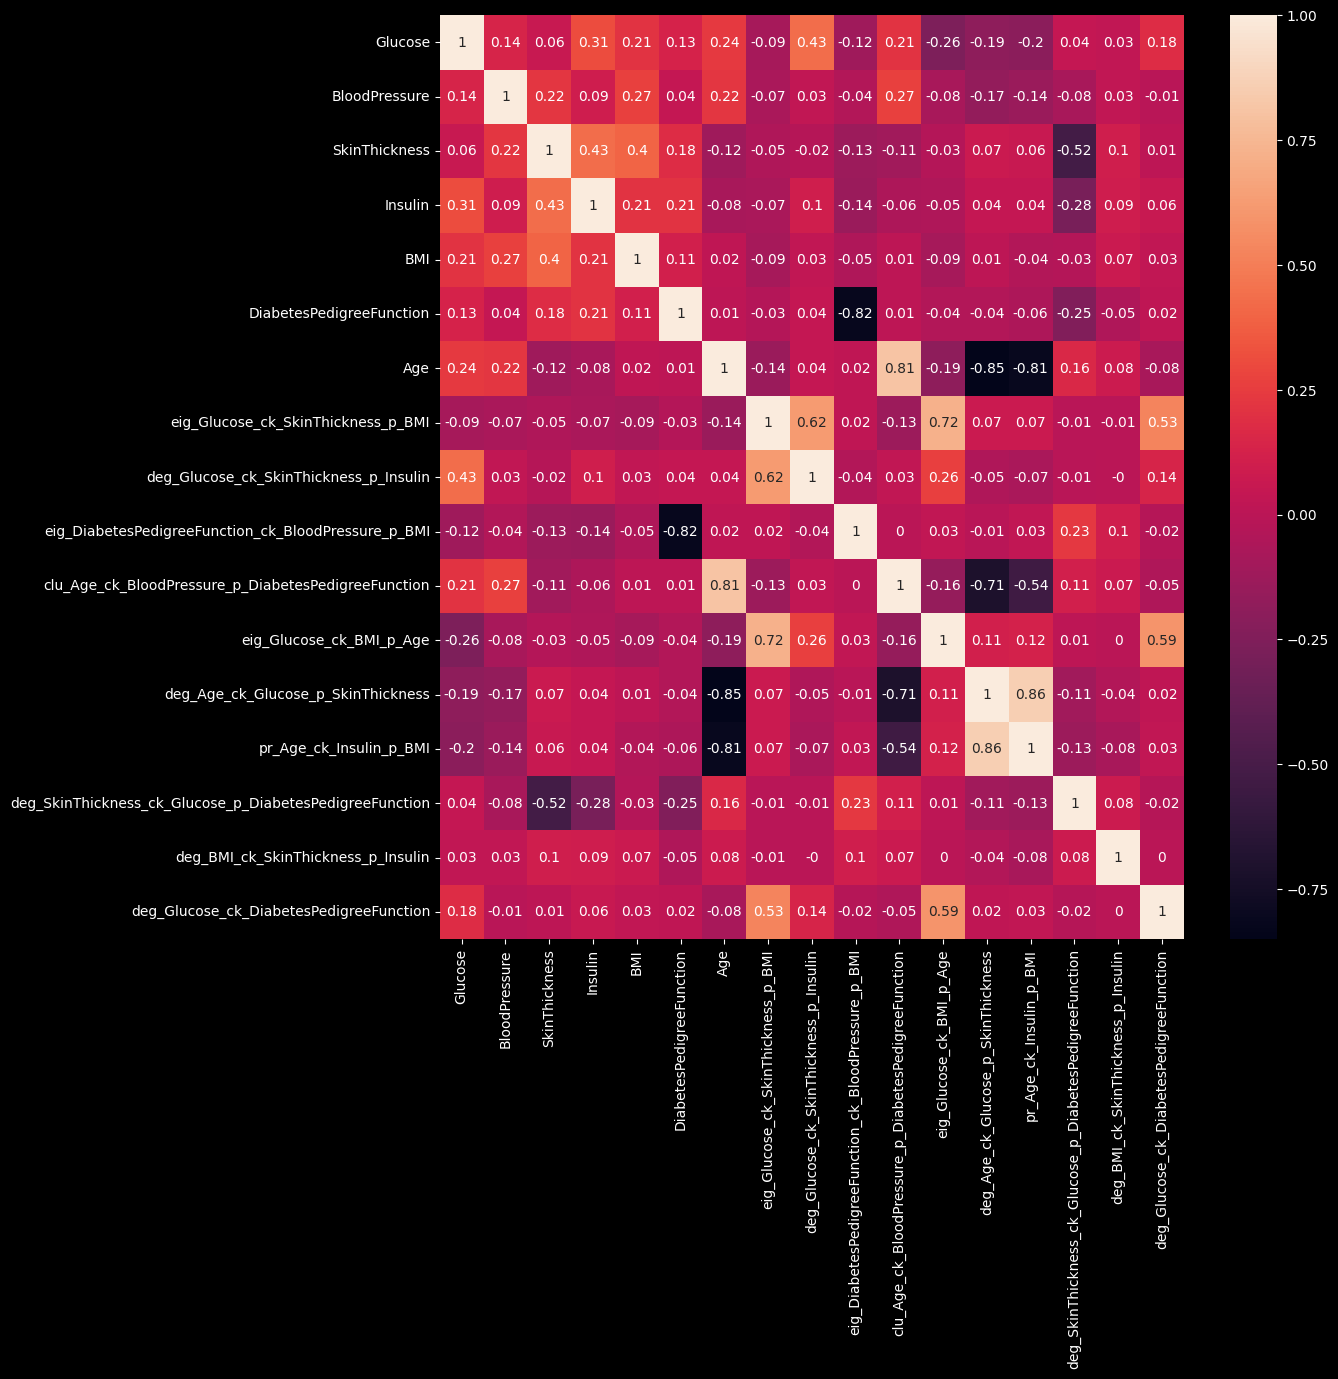

In [ ]:
# 11.2 Correlation heatmap:
plt.figure(figsize = (12,12))
sns.heatmap(np.round(result.corr(),2), annot = True) ;

## Distribution of columns
Distribution of columns related to different centrality measures

### Proportion of columns by centrality measure:

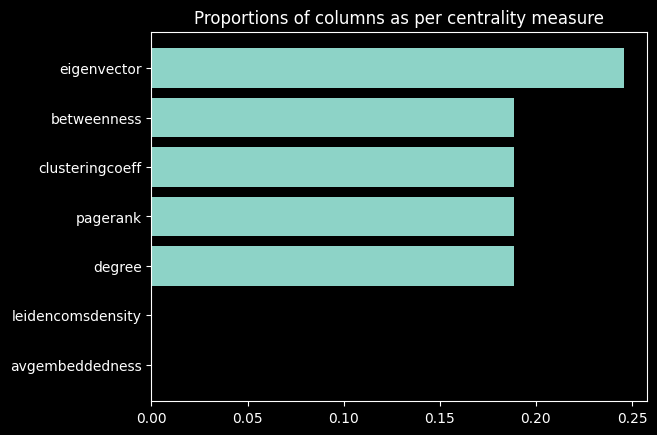

In [ ]:
# 12.0 Our list of columns

colList = (train_trans.iloc[:,len(cat_cols):]).columns

# Count of columns by centrality measure and its plot:
f = utils.featureImptByCentFeatCounts(colList, normalize = True)
utils.plotSeries(f, "Proportions of columns as per centrality measure")

### Proportions of columns by centrality whose impt is > 0

In [ ]:
# 12.1 Extract column importance:

fe_1, fe_0,_ = utils.xgImptFeatures(model_trans, colList)
f"Columns whose impt is >0: {len(fe_1)}"
print("\n")
f"Columns whose impt is 0: {len(fe_0)}"


Order of feature importance is by 'gain'


'Columns whose impt is >0: 507'

'Columns whose impt is 0: 262'

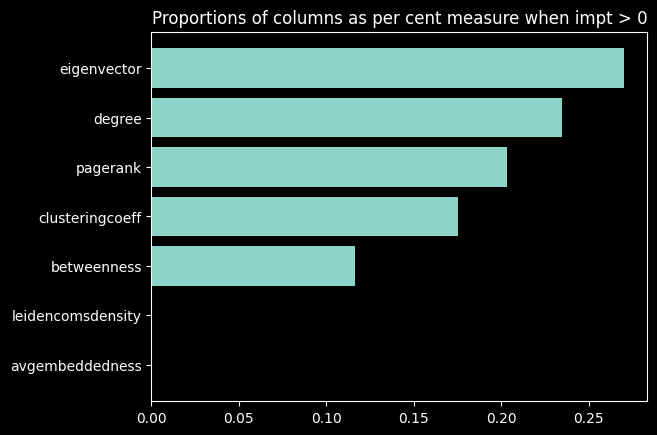

In [ ]:
# 12.2 Count of columns whose xgboost impt > 0 by centrality measure and its plot:
f = utils.featureImptByCentFeatCounts(fe_1, normalize = True)
utils.plotSeries(f, "Proportions of columns as per cent measure when impt > 0")

### Proportions of columns by summed-up importance score of each centrality measure

In [ ]:
# 13.0 Extract xgboost feature importance:
fe_1, _, fe = utils.xgImptFeatures(model_trans, colList)



Order of feature importance is by 'gain'


In [ ]:
# 13.1 Column-wise importance score (whose impt > 0)
#      score is a Pandas Series
score = fe['imp'][fe_1]

# 13.2 Score of top-five columns:
score[:5]

eig_Glucose_ck_SkinThickness_p_BMI                     0.023684
deg_Glucose_ck_SkinThickness_p_Insulin                 0.020059
eig_DiabetesPedigreeFunction_ck_BloodPressure_p_BMI    0.016031
clu_Age_ck_BloodPressure_p_DiabetesPedigreeFunction    0.014380
eig_Glucose_ck_BMI_p_Age                               0.010553
Name: imp, dtype: float32

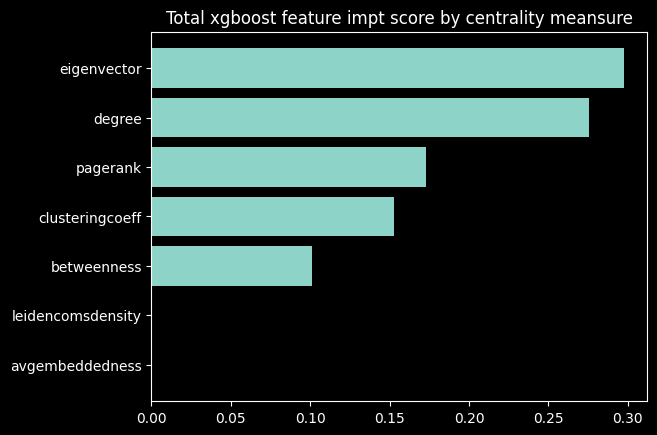

In [ ]:
# 13.3 Extract and plot total xgboost impt scores by centrality measure:

g = utils.featureImptByScore(score, fe_1, True)
utils.plotSeries(g, "Total xgboost feature impt score by centrality meansure")

## Mutual information

In [ ]:
from sklearn.feature_selection import mutual_info_classif



In [ ]:
mi_scores = utils.calMIScores(train_trans[colList], ytr)
mi_scores[::3]  # show a few features with their MI scores

eig_area_mean_ck_concavity_worst_p_concavity_mean       0.411510
eig_area_mean_ck_area_mean_p_area_se                    0.398181
eig_area_mean_ck_area_mean_p_texture_mean               0.396951
eig_area_mean_ck_area_se_p_concavity_worst              0.388818
eig_area_mean_ck_area_mean_p_concavity_worst            0.386731
                                                          ...   
deg_texture_mean_ck_concavity_worst_p_concavity_mean    0.048080
eig_area_se_ck_concavity_worst                          0.043185
deg_texture_mean_ck_area_mean_p_concavity_worst         0.032534
bet_texture_mean_ck_area_se                             0.011870
pr_texture_mean_ck_area_se                              0.000000
Name: MI Scores, Length: 90, dtype: float64

In [ ]:
fe.cumsum()
len(fe)